# Session-based Product Recommendation using Word2vec Algorithm.

# Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#get google colab GPU info 
# remember to change in run time

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install ray==1.9.0

     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 241 kB 76.6 MB/s 


In [5]:
!pip install argparse==1.1
!pip install pandas==1.1.5
!pip install seaborn==0.11.2
#!pip install numpy==1.19.5
!pip install matplotlib==3.2.2
#!pip install gensim==3.6.0

     |████████████████████████████████| 151 kB 13.0 MB/s 
  Created wheel for argparse: filename=argparse-1.1-py3-none-any.whl size=20735 sha256=ab09d762c5575bdad8458e0ee35b3db5ba4ab230d7a9afc2faefca6db42310d9
  Stored in directory: /root/.cache/pip/wheels/59/e1/77/ca719b6be5cfdef5d09090cb37f86df1d9bbdd0749a0e48860
Successfully built argparse


     |████████████████████████████████| 9.5 MB 13.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [4]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2 MB 13.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Import Libraries

In [3]:
#import libraries 
import os
import time
import json 
import argparse
import pickle
import collections
import itertools
from numpy.random import default_rng

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ray 
from ray import tune

In [4]:
%matplotlib inline

In [5]:
#import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Load & Analyse Data

In [6]:
MODEL_DIR = "/content/content"

In [7]:
Path1 = '/content/drive/MyDrive/Colab Notebooks/Submission/Datasets/sample_sessions_1.txt'

In [8]:
with open(Path1, 'r') as f:
    sessions = json.loads(f.read())

In [9]:
sessions[1]

['J56607h', 'J46300q', 'K19032n']

In [10]:
print(len(sessions))

549312


# Train/Test Split

In [11]:
rng = default_rng(123)

In [12]:
def train_test_split(session_sequences, test_size: int = 120000, rng=rng):
    
    ## Construct training set
    # Drop last item, use (1 st, ..., n-1 th) items for train set 
    train = [sess[:-1] for sess in session_sequences]

    ## Construct test and validation sets
    # sub-sample 120k sessions (slightly more than 10% of total unique sessions), use (n-1 th, n th) to form the
    # disjoint validaton and test sets
    test_validation = [sess[-2:] for sess in session_sequences]
    index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
    test = np.array(test_validation)[index[:test_size]].tolist()
    validation = np.array(test_validation)[index[test_size:]].tolist()

    return train, test, validation

In [13]:
#split session data list into train, test and validation 
print(len(sessions))
train, test, valid = train_test_split(sessions, test_size=80000)
print(len(train), len(valid), len(test))

549312
549312 80000 80000


# Define Evaluation metrics

In [14]:
#Recall_at_K
def recall_at_k(test, embed, k: int = 10) -> float:

    ratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embed.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            ratk_score += 1
    ratk_score /= len(test)
    return ratk_score

In [15]:
def mrr_at_k(test, embed, k: int) -> float:

    mrratk_score = 0
    for query_item, ground_truth in test:
        # get the k most similar items to the query item (computes cosine similarity)
        neighbors = embed.similar_by_vector(query_item, topn=k)
        # clean up the list
        recommendations = [item for item, score in neighbors]
        # check if ground truth is in the recommedations
        if ground_truth in recommendations:
            # identify where the item is in the list
            rank_idx = (
                np.argwhere(np.array(recommendations) == ground_truth)[0][0] + 1
            )
            # score higher-ranked ground truth higher than lower-ranked ground truth
            mrratk_score += 1 / rank_idx
    mrratk_score /= len(test)
    return mrratk_score

# Modeling with Logging

In [16]:
%load_ext tensorboard

In [17]:
from copy import deepcopy

In [18]:
ray.init(num_cpus=4, ignore_reinit_error=True)

{'metrics_export_port': 51751,
 'node_id': '102d26518c3b8779e08044c61a43aeab233a5cb2992c102056d92527',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2022-05-08_16-38-22_424724_438/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2022-05-08_16-38-22_424724_438/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2022-05-08_16-38-22_424724_438',
 'webui_url': None}

In [19]:

def train_w2v(train_data, params:dict, callbacks=None, model_name=None):
    if model_name: 
        # Load a model for additional training. 
        model = Word2Vec.load(model_name)
    else: 
        # train model
        if callbacks:
            model = Word2Vec(callbacks=callbacks, **params)
        else:
            model = Word2Vec(**params)
        model.build_vocab(train_data)

    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
    vectors = model.wv
    return vectors

def tune_w2v(config):
    ratk_logger = RecallAtKLogger(valid, k=config['k'], ray_tune=True)

    # remove keys from config that aren't hyperparameters of word2vec
    config.pop('dataset')
    config.pop('k')
    train_w2v(train, params=config, callbacks=[ratk_logger])

class RecallAtKLogger(CallbackAny2Vec):
    '''Report Recall@K at each epoch'''
    def __init__(self, validation_set, k, ray_tune=False, save_model=False):
        self.epoch = 0
        self.recall_scores = []
        self.validation = validation_set
        self.k = k
        self.tune = ray_tune
        self.save = save_model

    def on_epoch_begin(self, model):
        if not self.tune:
            print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        # method 1: deepcopy the model and set the model copy's wv to None
        mod = deepcopy(model)
        mod.wv.norms = None # will cause it recalculate norms? 
        
        # Every 10 epochs, save the model 
        if self.epoch%10 == 0 and self.save: 
            # method 2: save and reload the model
            model.save(f"{MODEL_DIR}w2v_{self.epoch}.model")
            #mod = Word2Vec.load(f"w2v_{self.epoch}.model")
        
        ratk_score = recall_at_k(self.validation, mod.wv, self.k)  

        if self.tune: 
            tune.report(recall_at_k = ratk_score)    
        else:
            self.recall_scores.append(ratk_score)
            print(f' Recall@10: {ratk_score}')
        self.epoch += 1


class LossLogger(CallbackAny2Vec):
    '''Report training loss at each epoch'''
    def __init__(self):
        self.epoch = 0
        self.previous_loss = 0
        self.training_loss = []

    def on_epoch_end(self, model):
        # the loss output by Word2Vec is more akin to a cumulative loss and increases each epoch
        # to get a value closer to loss per epoch, we subtract
        cumulative_loss = model.get_latest_training_loss()
        loss = cumulative_loss - self.previous_loss
        self.previous_loss = cumulative_loss
        self.training_loss.append(loss)
        print(f' Loss: {loss}')
        self.epoch += 1

In [20]:
expt_dir = '/content/content/HPO1'

Epoch: 0	 Recall@10: 0.3701625
 Loss: 1549616.125
Epoch: 1	 Recall@10: 0.3708
 Loss: 908103.125
Epoch: 2	 Recall@10: 0.3637125
 Loss: 762529.25
Epoch: 3	 Recall@10: 0.3595875
 Loss: 784465.0
Epoch: 4	 Recall@10: 0.3577
 Loss: 697199.0


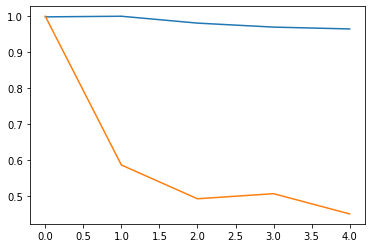

0.36105
0.20087029265874545


In [21]:
use_saved_expt = False
if use_saved_expt:
  analysis = Analysis(expt_dir, default_metric="recall_at_k", default_mode="max")
  w2v_params = analysis.get_best_config()
else:
  w2v_params = {
          "min_count": 1,
          "iter": 5,
          "workers": 10,
          "sg": 1,
      }

# Instantiate callback to measurs Recall@K on the validation set after each epoch of training
ratk_logger = RecallAtKLogger(valid, k=10, save_model=True)
# Instantiate callback to compute Word2Vec's training loss on the training set after each epoch of training
loss_logger = LossLogger()
# Train Word2Vec model and retrieve trained embeddings
embeddings = train_w2v(train, w2v_params, [ratk_logger, loss_logger])

# Save results
pickle.dump(ratk_logger.recall_scores, open(os.path.join("/content", f"recall@k_per_epoch.pkl"), "wb"))
pickle.dump(loss_logger.training_loss, open(os.path.join("/content", f"trainloss_per_epoch.pkl"), "wb"))

# Save trained embeddings
embeddings.save(os.path.join("/content", f"embeddings.wv"))

# Visualize metrics as a function of epoch
plt.plot(np.array(ratk_logger.recall_scores)/np.max(ratk_logger.recall_scores))
plt.plot(np.array(loss_logger.training_loss)/np.max(loss_logger.training_loss))
plt.show()

# Print results on the test set
print(recall_at_k(test, embeddings, k=10))
print(mrr_at_k(test, embeddings, k=10))

# Hyperparameter Tuning with Ray

In [22]:
#from ray.tune import Analysis
from ray.tune.schedulers import ASHAScheduler

In [ ]:
"""
The three main hyperparameters that we are looking into are:

context window size  W
Negative sampling exponent ns
number of sample sizes ng

w -> [start,end,step size] -> [1,10,2]
ns -> [start, end, step size] -> [-1, 1, 0.2]
ng -> [start, end, step size] -> [1,10,2]

con = 5,11,5

"""

In [ ]:
"""
In the interest of time, we have to work smart. The above idea which will have 275 trails will take too long, 
it may take 24 to 35 hours. Thus, we have be smart. 

We would have to work with 2 variables like w and ng (25 trails) | w and ns (35 trails) etc.  to save time

I would have to make educated guess on what might be the best hyper parameters. 

"""

In [ ]:
# Define the hyperparameter search space for Word2Vec algorithm
search_space = {
    "dataset": "Coveo_1",
    "k": 10,
    #"size": tune.grid_search(list(np.arange(10,125, 25))),
    #"window": tune.grid_search(list(np.arange(1,20, 4))),
    "ns_exponent": tune.grid_search(list(np.arange(-1, 1.3, .3))),
    #"alpha": tune.grid_search([0.001, 0.01, 0.1]),
    #"negative": tune.grid_search(list(np.arange(1,20, 4))),
    "iter": 5,
    "min_count": 1,
    "workers": 6,
    "sg": 1,
}

use_asha = True
smoke_test = False

# The ASHA Scheduler will stop underperforming trials in a principled fashion
asha_scheduler = ASHAScheduler(max_t=100, grace_period=10) if use_asha else None

# Set the stopping critera -- use the smoke-test arg to test the system 
stopping_criteria = {"training_iteration": 1 if smoke_test else 9999}

# Perform hyperparamter sweep with Ray Tune
analysis = tune.run(
    tune_w2v,
    name=expt_dir,
    local_dir="ray_results",
    metric="recall_at_k",
    mode="max",
    scheduler=asha_scheduler,
    stop=stopping_criteria,
    num_samples=1,
    verbose=1,
    resources_per_trial={
        "cpu": 1,
        "gpu": 0
    },
    config=search_space,
)
print("Best hyperparameters found were: ", analysis.best_config)

2022-05-08 05:31:56,922	INFO tune.py:626 -- Total run time: 1772.93 seconds (1771.03 seconds for the tuning loop).


Best hyperparameters found were:  {'dataset': 'Coveo_1', 'k': 10, 'size': 35, 'iter': 5, 'min_count': 1, 'workers': 6, 'sg': 1}


# HPO Analysis

In [ ]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/recall@k_per_epoch.pkl (stored 0%)
  adding: content/model/contentw2v_0.model (deflated 30%)
  adding: content/model/embeddings.wv (deflated 29%)
  adding: content/model/trainloss_per_epoch.pkl (deflated 25%)


In [ ]:
!zip -r /content/content/HPO_Results1.zip /content/content/HPO1

  adding: content/content/HPO1/ (stored 0%)
  adding: content/content/HPO1/tune_w2v_0d697_00002_2_size=60_2022-05-08_05-02-41/ (stored 0%)
  adding: content/content/HPO1/tune_w2v_0d697_00002_2_size=60_2022-05-08_05-02-41/progress.csv (deflated 64%)
  adding: content/content/HPO1/tune_w2v_0d697_00002_2_size=60_2022-05-08_05-02-41/params.json (deflated 28%)
  adding: content/content/HPO1/tune_w2v_0d697_00002_2_size=60_2022-05-08_05-02-41/params.pkl (deflated 13%)
  adding: content/content/HPO1/tune_w2v_0d697_00002_2_size=60_2022-05-08_05-02-41/result.json (deflated 81%)
  adding: content/content/HPO1/basic-variant-state-2022-05-08_05-02-25.json (deflated 52%)
  adding: content/content/HPO1/experiment_state-2022-05-08_05-02-25.json (deflated 92%)
  adding: content/content/HPO1/tune_w2v_0d697_00004_4_size=110_2022-05-08_05-02-46/ (stored 0%)
  adding: content/content/HPO1/tune_w2v_0d697_00004_4_size=110_2022-05-08_05-02-46/progress.csv (deflated 64%)
  adding: content/content/HPO1/tune_w2v

In [ ]:
/content/results

In [ ]:
!zip -r /content/results/Results1.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/recall@k_per_epoch.pkl (stored 0%)
  adding: content/results/contentw2v_0.model (deflated 30%)
  adding: content/results/embeddings.wv (deflated 29%)
  adding: content/results/trainloss_per_epoch.pkl (deflated 19%)
